<a href="https://www.kaggle.com/code/esracum/fruit-freshness-classification-deep-learning?scriptVersionId=290587989" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Single Image Prediction## Binary Image Classification (Fresh vs Rotten Fruits)
### Using Transfer Learning with MobileNetV2

## 📌 Project Overview
Fruit freshness detection is an important problem in:

* Supply chain management 

* Waste reduction

In this project, we build a deep learning model that classifies fruit images as:

* Fresh

* Rotten

We use Transfer Learning to achieve high accuracy with limited data. 

## 🔹Approach Summary

Task: Binary image classification

Model: MobileNetV2 (pretrained on ImageNet)

Framework: TensorFlow / Keras

Input Size: 224 × 224 RGB images

Loss: Binary Crossentropy

Metric: Accuracy

## 🔹 Dataset Structure

* fresh-vs-rotten-fruit-images/
* ├── apple/
* │   ├── fresh/
* │   │   ├── img1.jpg
* │   │   ├── img2.jpg
* │   │   └── ...
* │   ├── rotten/
* │   
* ├── banana/
* │   ├── fresh/
* │   ├── rotten/
* │
* ......
 

## 🔹Import Required Libraries

In [12]:
import tensorflow as tf
print(tf.__version__)


2.19.0


In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


## 🔹 Dataset Path

In [33]:
import shutil, os

dst = "/kaggle/working/data"

if os.path.exists(dst):
    shutil.rmtree(dst)

os.makedirs(dst)


In [34]:
import os, shutil

src = "/kaggle/input/fresh-vs-rotten-fruit-images/Fruit Freshness Dataset/Fruit Freshness Dataset"
dst = "/kaggle/working/data"

for fruit in ["Apple", "Banana", "Strawberry"]:
    fruit_dir = os.path.join(src, fruit)

    for state in ["Fresh", "Rotten"]:
        state_dir = os.path.join(fruit_dir, state)

        class_name = f"{fruit}_{state}"
        target_dir = os.path.join(dst, class_name)
        os.makedirs(target_dir, exist_ok=True)

        for img in os.listdir(state_dir):
            shutil.copy(
                os.path.join(state_dir, img),
                os.path.join(target_dir, img)
            )


In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

gen = ImageDataGenerator()
check = gen.flow_from_directory("/kaggle/working/data")

print(check.class_indices)


Found 529 images belonging to 6 classes.
{'Apple_Fresh': 0, 'Apple_Rotten': 1, 'Banana_Fresh': 2, 'Banana_Rotten': 3, 'Strawberry_Fresh': 4, 'Strawberry_Rotten': 5}


## 🔹 Data Preprocessing & Augmentation

We apply:

* Rescaling (normalization)

* Data augmentation to reduce overfitting

* Automatic train/validation split

In [39]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

datagen = ImageDataGenerator(
    rescale=1./255,            # Normalization
    rotation_range=20,         # Data augmentation
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2       # %80 train / %20 validation
)

train_generator = datagen.flow_from_directory(
    "/kaggle/working/data",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    "/kaggle/working/data",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)


Found 426 images belonging to 6 classes.
Found 103 images belonging to 6 classes.


## 🔹 Class Labels

In [40]:
print(train_generator.class_indices)


{'Apple_Fresh': 0, 'Apple_Rotten': 1, 'Banana_Fresh': 2, 'Banana_Rotten': 3, 'Strawberry_Fresh': 4, 'Strawberry_Rotten': 5}


## 🔹Build the Model (Transfer Learning)

In [48]:
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False  # Freeze pretrained layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(6, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)


## 🔹 Compile the Model

In [49]:
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,726 (9.24 MB)

 Trainable params: 1,370,822 (5.23 MB)

 Non-trainable params: 1,051,904 (4.01 MB)

## 🔹 Train the Model

In [53]:
EPOCHS = 25

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)


Epoch 1/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 548ms/step - accuracy: 0.9231 - loss: 0.1316 - val_accuracy: 0.8738 - val_loss: 0.1388
Epoch 2/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 484ms/step - accuracy: 0.9458 - loss: 0.1215 - val_accuracy: 0.8350 - val_loss: 0.1383
Epoch 3/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 481ms/step - accuracy: 0.9597 - loss: 0.1096 - val_accuracy: 0.8641 - val_loss: 0.1361
Epoch 4/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 473ms/step - accuracy: 0.9164 - loss: 0.1206 - val_accuracy: 0.8641 - val_loss: 0.1302
Epoch 5/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 483ms/step - accuracy: 0.9725 - loss: 0.1011 - val_accuracy: 0.8641 - val_loss: 0.1294
Epoch 6/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 497ms/step - accuracy: 0.9235 - loss: 0.1023 - val_accuracy: 0.8835 - val_loss: 0.1338
Epoch 7/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 490ms/step - accuracy: 0.9318 - loss: 0.1049 - val_accuracy: 0.9029 - val_loss: 0.1237
Epoch 8/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 7s 489ms/step - accuracy: 0.9461 - loss: 0.1078 - val_accuracy: 0.

## 🔹 Training Results Visualization

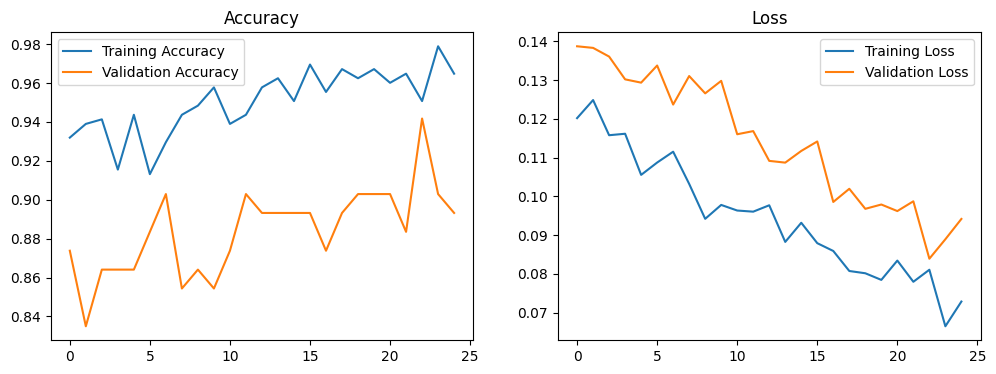

In [54]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Loss")

plt.show()
